# Проектна робота: Вплив даних отриманих з обробки сигналів на точність моделі


##### Виконав: Дмитро Калітін
##### Український Католицький Університет, Факультет прикладних наук, ПСА-20/Б
##### Курс: Обробка сигналів


## Аналіз даних (EDA)

In [1]:
import os
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_names = os.listdir("eeg-during-mental-arithmetic")[4:]

In [3]:
for file_name in file_names:
    edf_file = pyedflib.EdfReader(f"eeg-during-mental-arithmetic\\{file_name}")
    print(np.array(edf_file.getNSamples()) / np.array(edf_file.getSampleFrequencies()))
    print()
    edf_file.close()

[182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182.
 182. 182. 182. 182. 182. 182. 182.]

[62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.
 62. 62. 62.]

[182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182.
 182. 182. 182. 182. 182. 182. 182.]

[62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.
 62. 62. 62.]

[182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182.
 182. 182. 182. 182. 182. 182. 182.]

[62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.
 62. 62. 62.]

[182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182. 182.
 182. 182. 182. 182. 182. 182. 182.]

[62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.
 62. 62. 62.]

[170. 170. 170. 170. 170. 170. 170. 170. 170. 170. 170. 170. 170. 170.
 170. 170. 170. 170. 170. 170. 170.]

[62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.
 62. 62. 62.]

[182. 182. 182.

In [4]:
def generate_time_counts(duration=1, fs=128):
    t = np.linspace(0, duration - 1/fs, int(duration*fs))
    return t

In [5]:
def read_edf_file(file_name):
    """
    Returns 4 variables: t(time_counts), signals, fs, labels
    """
    edf_file = pyedflib.EdfReader(f"eeg-during-mental-arithmetic\\{file_name}")
    fs = edf_file.getSampleFrequency(0)
    n_samples = edf_file.getNSamples()[0]
    t = generate_time_counts(duration=n_samples/fs, fs=fs)[:int(-2*fs)] # Cut last two seconds that do not have any valuable information
    labels = edf_file.getSignalLabels()
    signals = []
    for i in range(21):
        signals.append(edf_file.readSignal(i)[:int(-2*fs)])
    edf_file.close()
    return t, signals, fs, labels

### Графіки ЕЕГ каналів

In [6]:
def get_sample(file_name, verbose=False):
    t, signals, fs, labels = read_edf_file(file_name)
    if verbose:
        plt.figure(figsize=(20, 42))
        for i in range(21):
            plt.subplot(21, 1, i+1)
            plt.plot(t, np.array(signals[i]))
            plt.title(labels[i])
            plt.xlabel('Time, s')
            plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.show()
    edf_file.close()
    return t, signals, fs

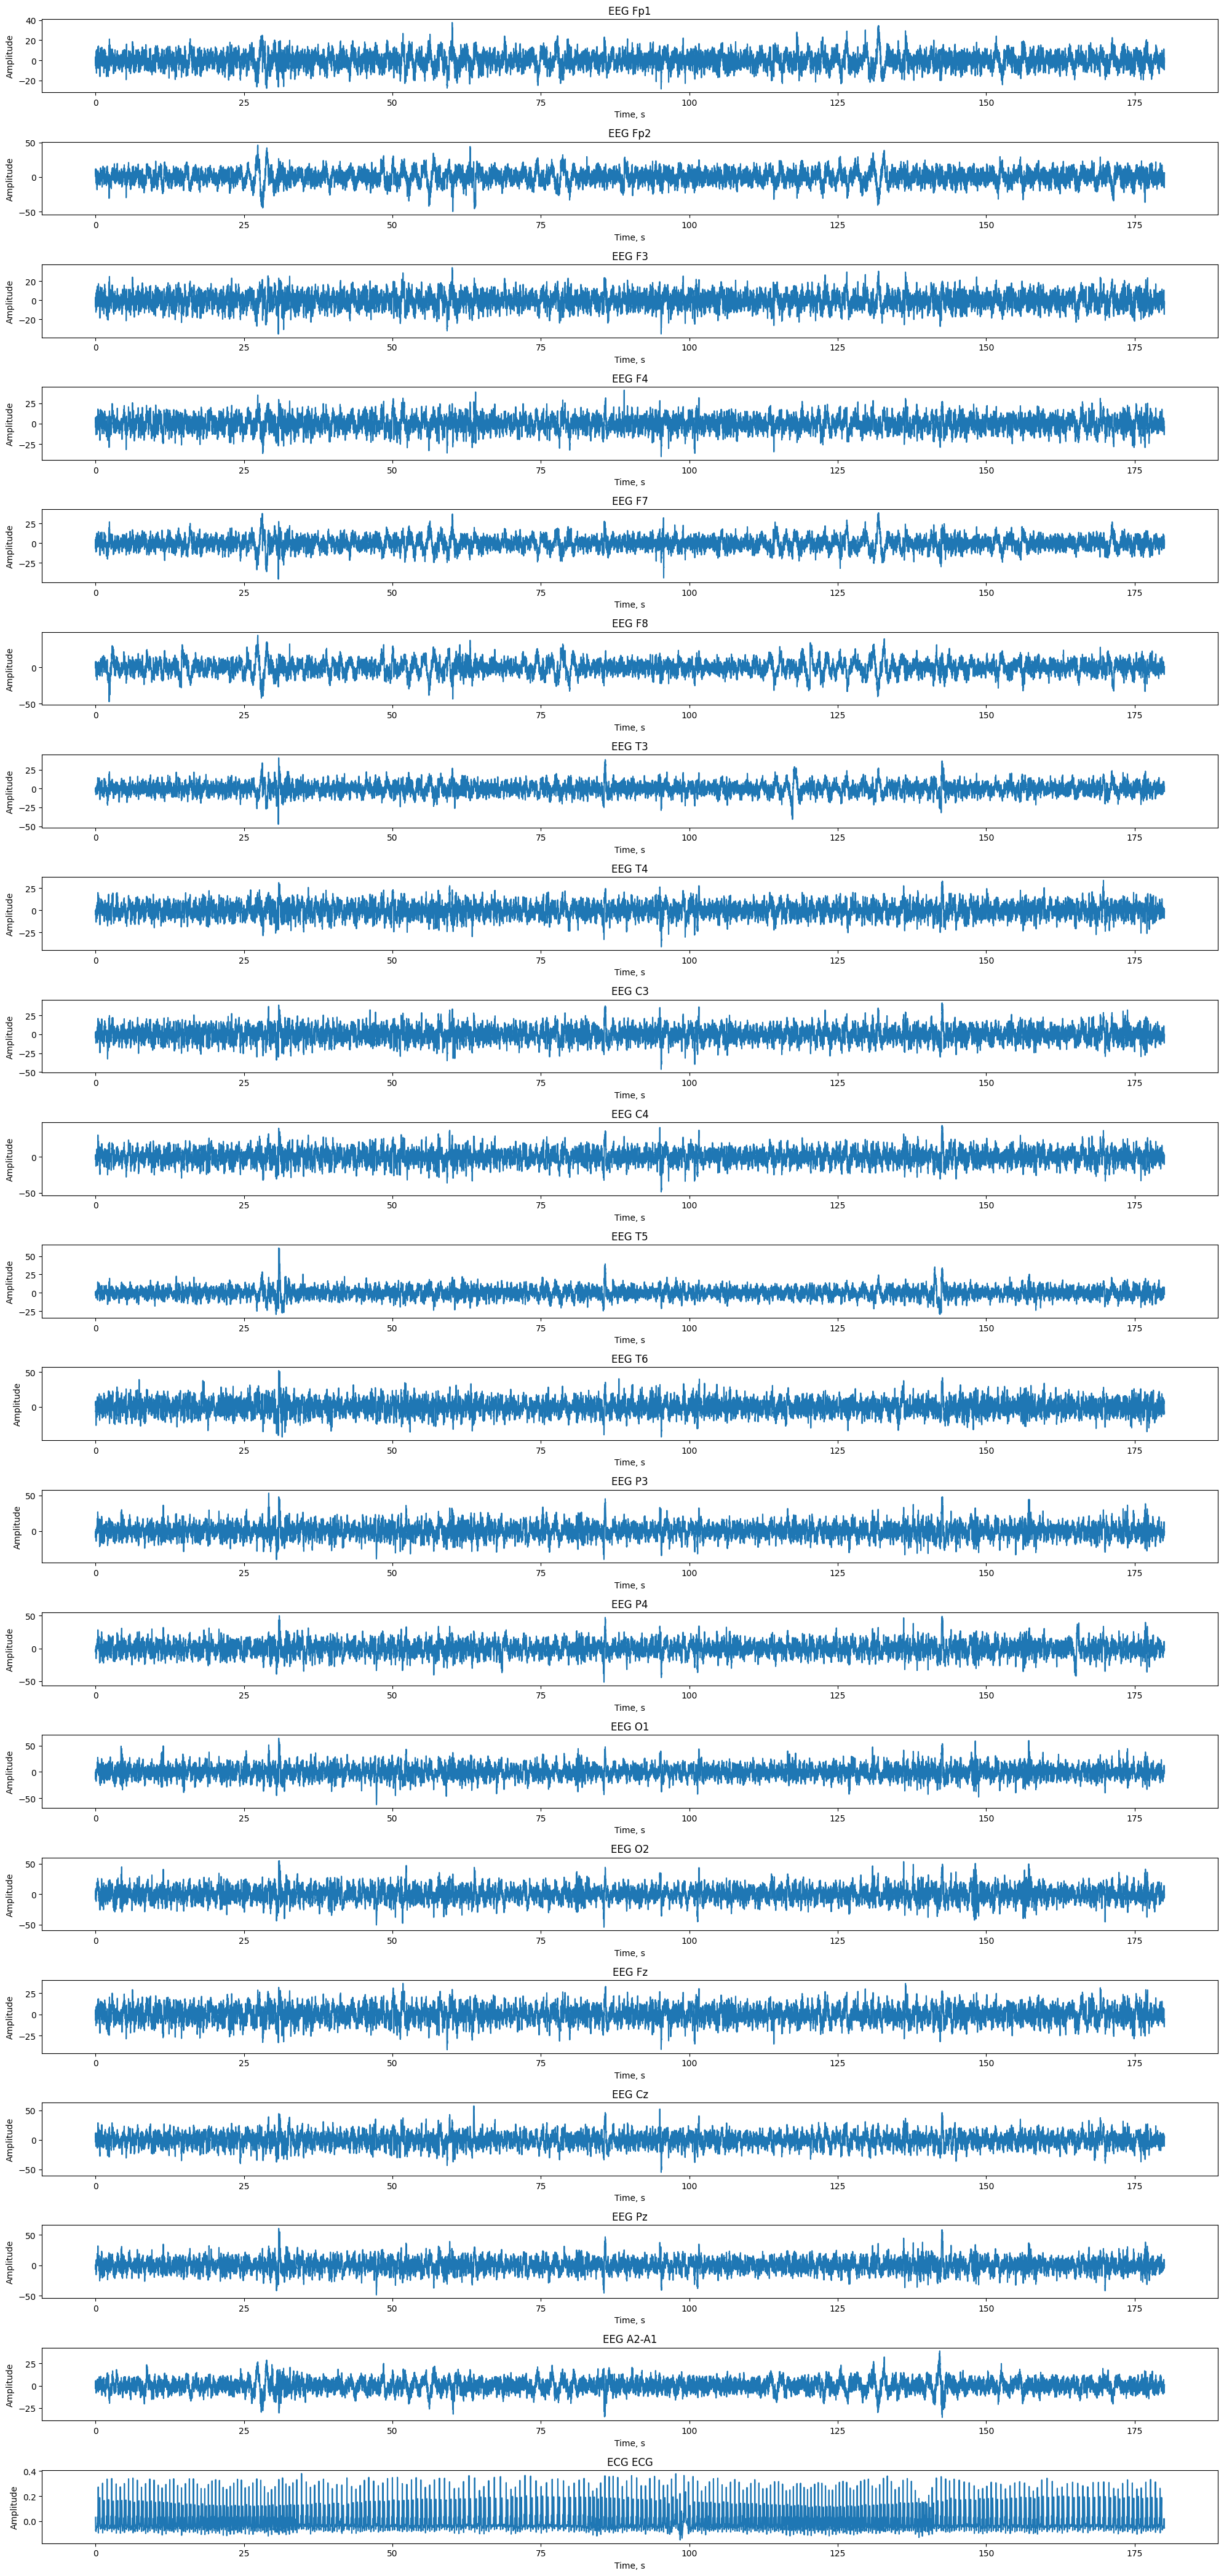

In [7]:
t, signals, fs = get_sample("Subject17_1.edf", verbose=True)

### Огляд даних спектрограм. Підбір парамерів.

In [8]:
import scipy.signal

In [9]:
def get_sample_spectrogram(file_name, verbose=False):
    t, signals, fs, labels = read_edf_file(file_name)
    spectrograms = []

    if verbose:
        plt.figure(figsize=(20, 42))
    for i in range(21):
        if verbose:
            plt.subplot(21, 1, i+1)

        signal = signals[i]
        window_duration = 0.1
        flat_top_window = scipy.signal.get_window('flattop', int(fs * window_duration))
        freqs, _, spectrogram = scipy.signal.spectrogram(signal, fs=fs, window=flat_top_window, noverlap=len(flat_top_window)//2, nperseg=len(flat_top_window))
        spectrogram = 10 * np.log10(spectrogram)
        spectrograms.append(spectrogram)
        if verbose:
            plt.imshow(spectrogram, cmap='inferno', aspect='auto', origin='lower', extent=[t[0], t[-1], freqs[0], freqs[-1]])
            plt.title(labels[i])
            plt.colorbar(label='dB')
            plt.xlabel('Time, s')
            plt.ylabel('Frequency, Hz')

    if verbose:
        plt.tight_layout()
        plt.show()
    edf_file.close()
    return t, spectrograms, freqs

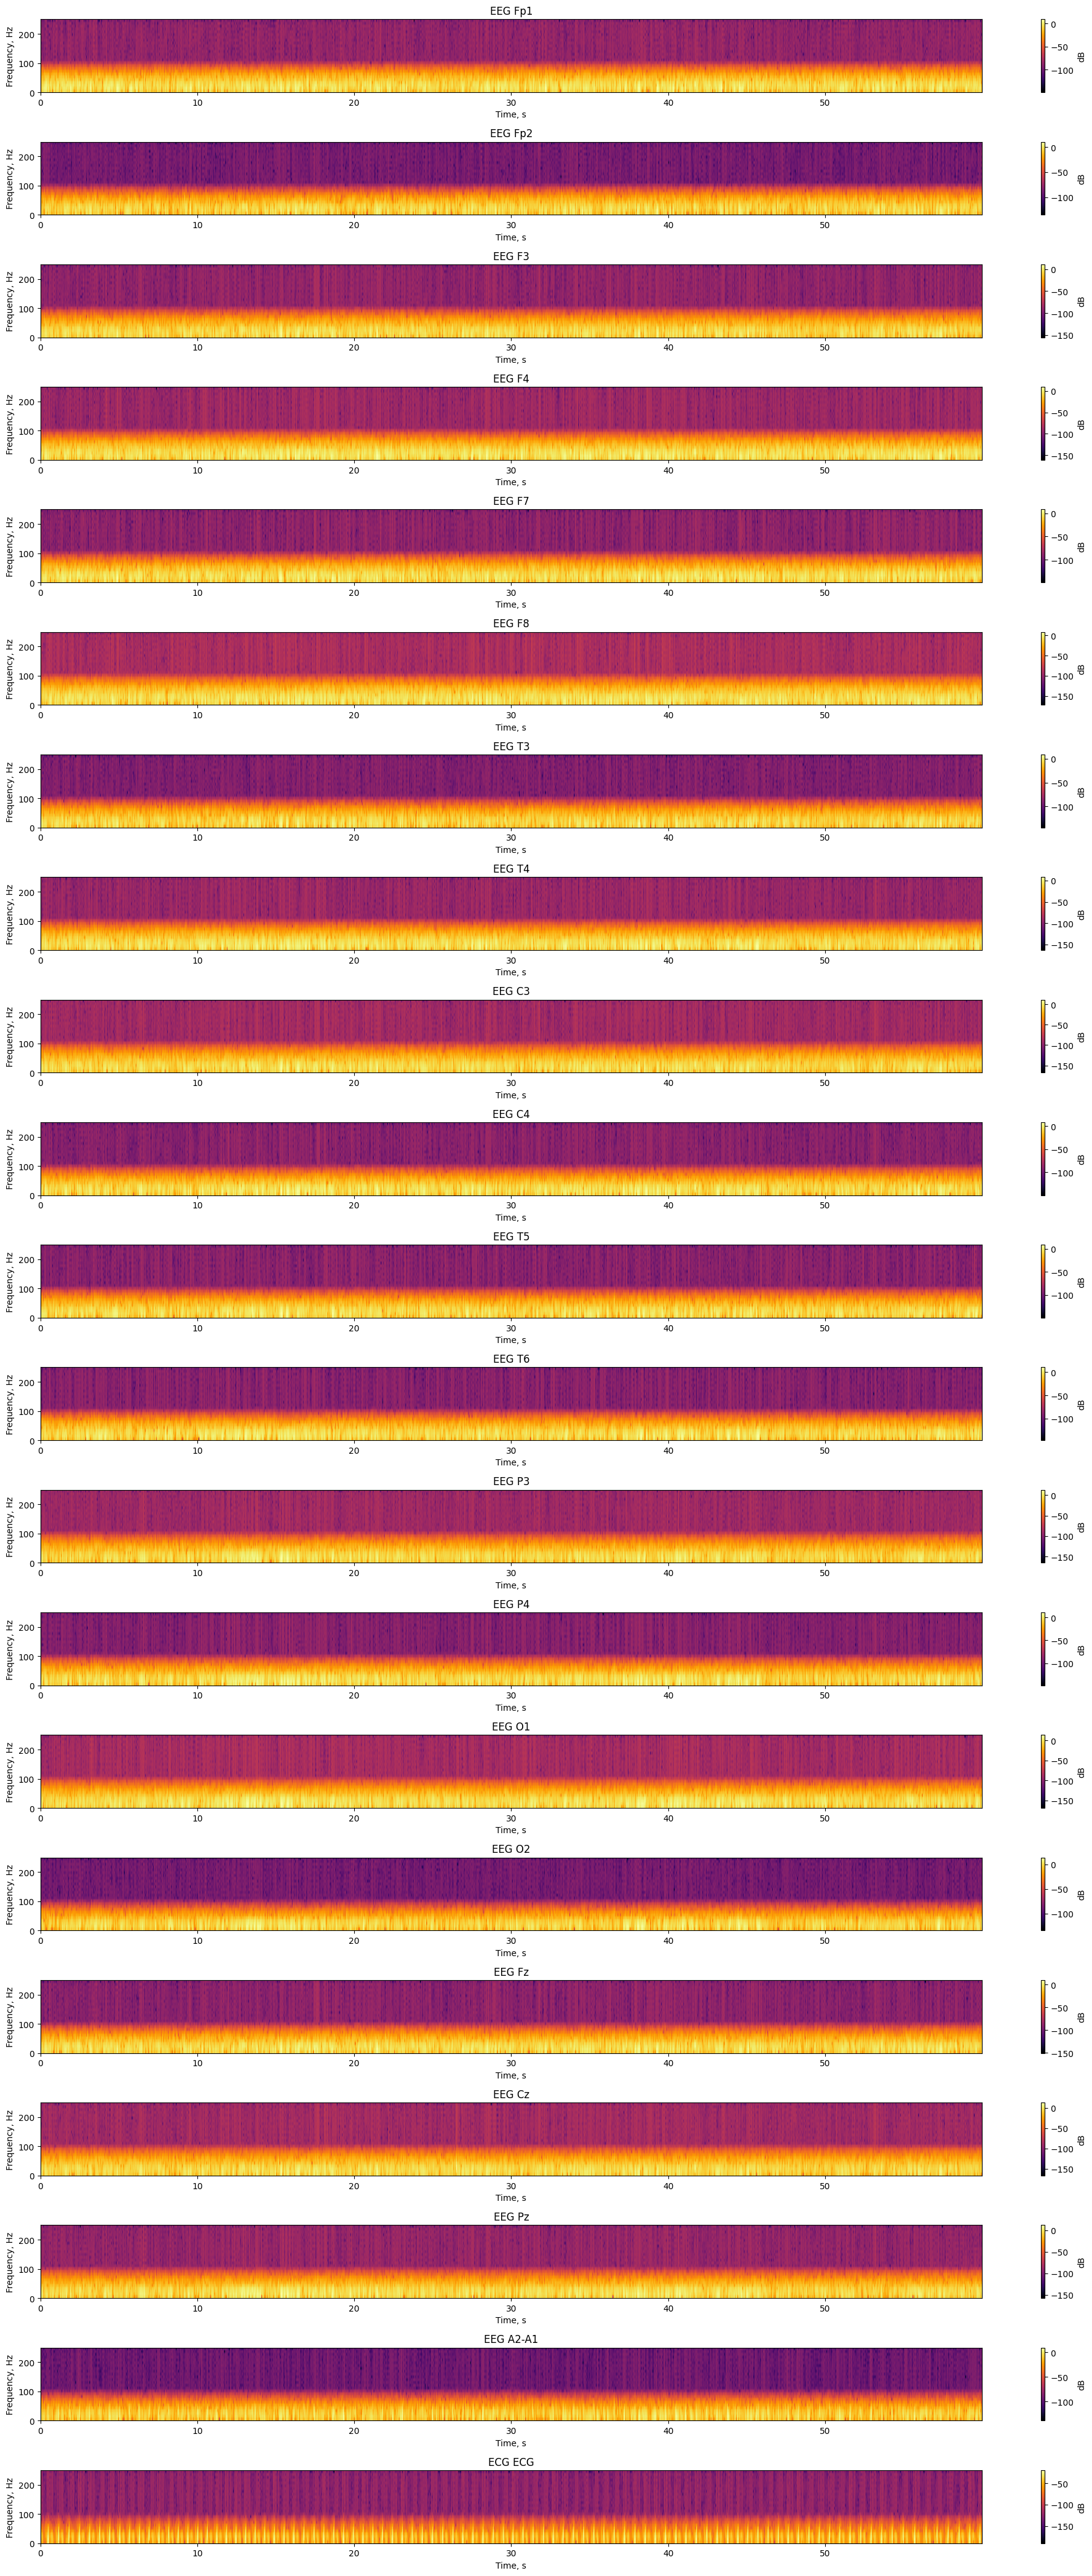

In [10]:
t, spectrograms, freqs = get_sample_spectrogram("Subject08_2.edf", verbose=True)

In [11]:
np.array(spectrograms).shape

(21, 26, 1199)

In [12]:
t.shape

(30000,)

In [13]:
freqs[-2]

240.0

### Розрахунок міжканальної фазової синхронності (ICPS).

In [14]:
def get_icps_sample_matrix(file_name, verbose=False):
    t, eeg_data, fs, _ = read_edf_file(file_name)
    # 1. Compute the instantaneous phase for each channel's signal using Hilbert Transform
    phase_data = [np.angle(np.exp(1j * np.angle(np.fft.fft(sig)))) for sig in eeg_data]

    # 2. Compute the phase differences between each pair of channels
    num_channels = len(phase_data)
    phase_diff = np.zeros((num_channels, num_channels))

    for i in range(num_channels):
        for j in range(i+1, num_channels):
            phase_diff[i, j] = np.abs(np.mean(np.exp(1j * (phase_data[i] - phase_data[j]))))

    # Fill the lower triangle of the matrix (as it's symmetric)
    phase_diff += phase_diff.T + np.diag(np.ones_like(phase_diff).diagonal())

    if verbose:
        plt.figure(figsize=(8, 8))
        plt.imshow(phase_diff, cmap='viridis', interpolation='nearest')

        plt.colorbar()  # Add color bar to show scale

        plt.title('Interchannel phase synchrony Heatmap')
        plt.xlabel('Channels')
        plt.ylabel('Channels')

        plt.show()

    return phase_diff

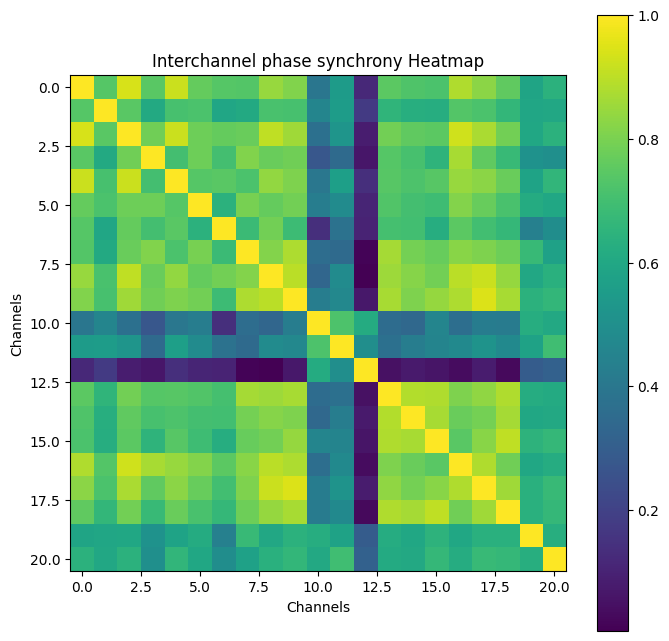

In [15]:
icsp = get_icps_sample_matrix("Subject17_1.edf", verbose=True)

## Побудова моделі

### Пре обробка даних

In [22]:
def preprocess_data():
    file_names = os.listdir("eeg-during-mental-arithmetic")[4:]
    df = pd.read_csv("eeg-during-mental-arithmetic\\subject-info.csv")
    for i in range(0, len(file_names)*2, 2):
        t_pre, signals_pre, fs = get_sample(f"{file_names[i]}")
        t_pre, spectrograms_pre, freqs = get_sample_spectrogram(f"{file_names[i]}")
        icsp_pre = get_icps_sample_matrix(f"{file_names[i]}")

        t, signals, fs = get_sample(f"{file_names[i+1]}")
        pre, spectrograms, freqs = get_sample_spectrogram(f"{file_names[i+1]}")
        icsp = get_icps_sample_matrix(f"{file_names[i+1]}")

        label = df.iloc[int(i/2), 5]

        features = {
            "signals_pre": np.array(signals_pre, dtype=np.float32),
            "spectrograms_pre": np.array(spectrograms_pre, dtype=np.float32),
            "icsp_pre": icsp_pre,
            "signals": np.array(signals, dtype=np.float32),
            "spectrograms": np.array(spectrograms, dtype=np.float32),
            "icsp": icsp,
            "label": label
        }
        np.savez(f"npz_data\\subject{int(i/2)}", **features)

In [23]:
preprocess_data()

IndexError: list index out of range

In [25]:
file = np.load("npz_data\\subject0.npz")
for key in file.files:
    print(key)
    print(file.get(key))
    print("Shape:", file.get(key).shape)
    print()

signals_pre
[[-3.6479375e+00 -4.2364817e+00 -4.9542184e+00 ...  4.2663050e+00
   4.5980587e+00  4.8899384e+00]
 [-3.5818663e+00 -4.2793884e+00 -5.0208488e+00 ...  7.3624549e+00
   8.8252373e+00  1.0143389e+01]
 [-4.0812469e+00 -4.7662191e+00 -5.7834549e+00 ...  2.1704073e+00
   1.3959792e+00  5.4743087e-01]
 ...
 [ 2.8221364e+00  5.3117270e+00  8.3672781e+00 ...  4.1686773e+00
   4.1464205e+00  4.5836091e+00]
 [ 1.2915419e+00  9.7321856e-01  5.7902539e-01 ... -3.8230739e+00
  -2.6146545e+00 -1.6168013e+00]
 [ 5.4130764e-03  1.9881437e-03 -3.1295714e-03 ... -2.0041093e-01
  -1.9651359e-01 -1.9005740e-01]]
Shape: (21, 90000)

spectrograms_pre
[[[  -6.8917923   -26.944336      1.0243962  ...   -4.2890434
    -16.825325     -3.5913606 ]
  [  -0.3865649   -20.456493      3.1914854  ...   -3.373345
    -10.713279     -1.9143202 ]
  [   3.8567324    -8.969984      1.7545155  ...   -5.6287785
     -5.57554      -3.1332421 ]
  ...
  [ -88.12622     -94.03917     -93.51771    ...  -82.58445
    

### Датасети

In [37]:
training_set_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24] # 1: 16, 0: 8
validation_set_indices = [22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] # 1: 10, 0: 2

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [39]:
class EEGTrainDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = os.path.join(os.getcwd(), data_dir)
        self.file_names = sorted(os.listdir(self.data_dir))
        self.indices = training_set_indices
                
    def __getitem__(self, index):
        file_name = self.file_names[self.indices[index]]
        features = dict(np.load(os.path.join(self.data_dir, file_name)))
        features = {k: torch.tensor(v, dtype=torch.float32) for k, v in features.items()}
        return features

    def __len__(self):
        return len(self.indices)

class EEGValDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = os.path.join(os.getcwd(), data_dir)
        self.file_names = sorted(os.listdir(self.data_dir))
        self.indices = validation_set_indices
                
    def __getitem__(self, index):
        file_name = self.file_names[self.indices[index]]
        features = dict(np.load(os.path.join(self.data_dir, file_name)))
        features = {k: torch.tensor(v, dtype=torch.float32) for k, v in features.items()}
        return features

    def __len__(self):
        return len(self.indices)


In [19]:
dataset = EEGValDataset("npz_data")
print(dataset[0])
print(len(dataset))

{'signals_pre': tensor([[-1.0267, -2.0116, -3.3385,  ...,  0.8176,  0.8102,  0.9045],
        [-1.7067, -2.6994, -3.9502,  ...,  1.2164,  1.9082,  2.6459],
        [-5.3923, -6.4636, -7.9084,  ..., -3.2717, -2.1826, -1.0564],
        ...,
        [-1.9629, -1.2174,  0.0577,  ...,  8.0221,  6.4674,  5.1173],
        [-2.8181, -2.7254, -2.5240,  ...,  1.7617,  1.9217,  2.1173],
        [-0.0304, -0.0344, -0.0390,  ..., -0.0107, -0.0115, -0.0098]]), 'spectrograms_pre': tensor([[[   5.1546,    9.4251,    9.9969,  ...,  -26.3726,  -29.6488,
           -37.9935],
         [   6.1644,   11.0087,   11.7268,  ...,  -13.4551,  -12.8878,
            -9.5953],
         [   2.4996,    8.2529,    9.0633,  ...,  -10.0949,   -3.6789,
            -4.8588],
         ...,
         [ -85.9059,  -80.2612,  -79.3313,  ...,  -83.3576,  -89.2998,
           -85.0026],
         [ -96.2352,  -76.5797,  -84.7421,  ..., -105.9842,  -79.1420,
           -89.1026],
         [ -92.5223,  -84.5759,  -86.3983,  ...,  

In [50]:
config = {
    "signal_features": True,
    "spectrogram_features": False,
    "icps_features": False,
    "include_pre_eeg": False,
    "learning_rate": 0.001
}

In [51]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

def init_binary_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

class PreSignalEncoder(nn.Module):
    def __init__(self) -> None:
        self.netmodules = nn.Sequential()

    def forward(self, x):
        return self.netmodules(x)

class PreSignalDecoder(nn.Module):
    def __init__(self) -> None:
        self.netmodules = nn.Sequential()

    def forward(self, x):
        return self.netmodules(x)

class PreSpectrogramEncoder(nn.Module):
    def __init__(self) -> None:
        self.netmodules = nn.Sequential()

    def forward(self, x):
        return self.netmodules(x)

class PreSpectrogramDecoder(nn.Module):
    def __init__(self) -> None:
        self.netmodules = nn.Sequential()

    def forward(self, x):
        return self.netmodules(x)

class PreICSPEncoder(nn.Module):
    def __init__(self) -> None:
        self.netmodules = nn.Sequential()

    def forward(self, x):
        return self.netmodules(x)

class PreICSPDecoder(nn.Module):
    def __init__(self) -> None:
        self.netmodules = nn.Sequential()

    def forward(self, x):
        return self.netmodules(x)

##########################################

class SignalEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=21, out_channels=32, kernel_size=12, stride=6, padding=0).apply(init_weights)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=48, kernel_size=3, stride=1).apply(init_weights)
        self.maxpool2 = nn.MaxPool1d(kernel_size=3, stride=3, return_indices=True)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=26592, out_features=64).apply(init_weights)

    def forward(self, x):
        x = self.conv1(x)
        x, indices1 = self.maxpool1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x, indices2 = self.maxpool2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)

        self.indices1 = indices1
        self.indices2 = indices2

        return x

class SignalDecoder(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config["icps_features"]:
            linear_in_features = 128
        else:
            linear_in_features = 64
        self.linear1 = nn.Linear(in_features=linear_in_features, out_features=26592).apply(init_weights)
        self.relu = nn.ReLU()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(48, 554))
        self.maxunpool1 = nn.MaxUnpool1d(kernel_size=5, stride=3)
        self.transconv1 = nn.ConvTranspose1d(in_channels=48, out_channels=32, kernel_size=3, stride=1, padding=0).apply(init_weights)
        self.maxunpool2 = nn.MaxUnpool1d(kernel_size=4, stride=3)
        self.transconv2 = nn.ConvTranspose1d(in_channels=32, out_channels=21, kernel_size=12, stride=6).apply(init_weights)

    def set_indices(self, indices1, indices2):
        self.indices1 = indices1
        self.indices2 = indices2

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.maxunpool1(x, self.indices2)
        x = self.transconv1(x)
        x = self.relu(x)
        x = self.maxunpool2(x, self.indices1)
        x = self.transconv2(x)

        return x

class SpectrogramEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=21, out_channels=32, kernel_size=(5,7), stride=(2,3), padding=(0,0)).apply(init_weights)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3,3), stride=(1,1)).apply(init_weights)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=4704, out_features=64).apply(init_weights)

    def forward(self, x):
        x = self.conv1(x)
        x, indices1 = self.maxpool1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x, indices2 = self.maxpool2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)

        self.indices1 = indices1
        self.indices2 = indices2
        return x

class SpectrogramDecoder(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config["icps_features"]:
            linear_in_features = 128
        else:
            linear_in_features = 64
        self.linear1 = nn.Linear(in_features=linear_in_features, out_features=4704).apply(init_weights)
        self.relu = nn.ReLU()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(48, 1, 98))
        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(3,3), stride=(2,2))
        self.transconv1 = nn.ConvTranspose2d(in_channels=48, out_channels=32, kernel_size=(3,3), stride=(1,1)).apply(init_weights)
        self.maxunpool2 = nn.MaxUnpool2d(kernel_size=(3,2), stride=(2,2))
        self.transconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=21, kernel_size=(6,8), stride=(2,3), padding=(0,0)).apply(init_weights)

    def set_indices(self, indices1, indices2):
        self.indices1 = indices1
        self.indices2 = indices2

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.maxunpool1(x, self.indices2)
        x = self.transconv1(x)
        x = self.relu(x)
        x = self.maxunpool2(x, self.indices1)
        x = self.transconv2(x)
        return x

class ICSPEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3,3), stride=(2,2), padding=(0,0)).apply(init_binary_weights)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=(3,3), stride=(1,1)).apply(init_binary_weights)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=576, out_features=64).apply(init_binary_weights)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)

        return x

class ICSPDecoder(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config["icps_features"]:
            linear_in_features = 128
        else:
            linear_in_features = 64
        self.linear1 = nn.Linear(in_features=linear_in_features, out_features=576).apply(init_binary_weights)
        self.relu = nn.ReLU()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(9, 8, 8))
        self.transconv1 = nn.ConvTranspose2d(in_channels=9, out_channels=3, kernel_size=(3,3), stride=(1,1)).apply(init_binary_weights)
        self.transconv2 = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=(3,3), stride=(2,2), padding=(0,0)).apply(init_binary_weights)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.transconv1(x)
        x = self.relu(x)
        x = self.transconv2(x)

        return x

class FinalEmbedding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config["icps_features"]:
            linear_in_feat = 128
        else:
            linear_in_feat = 64
        self.netmodules = nn.Sequential(
            nn.Linear(in_features=linear_in_feat, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout1d(p=.1),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
        self.netmodules.apply(init_weights)

    def forward(self, x):
        return self.netmodules(x)

class MainModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.SignalEncoder = SignalEncoder()
        self.SignalDecoder = SignalDecoder(config)
        self.SpectrogramEncoder = SpectrogramEncoder()
        self.SpectrogramDecoder = SpectrogramDecoder(config)
        self.ICSPEncoder = ICSPEncoder()
        self.ICSPDecoder = ICSPDecoder(config)
        self.FinalEmbedding = FinalEmbedding(config)
        self.bce = nn.BCELoss()
        self.mse = nn.MSELoss()

    def forward(self, features):
        signal_features = features["signals"]
        spectrogram_features = features["spectrograms"]
        icsp_features = torch.reshape(features["icsp"], (1, 1, 21, 21))
        label = torch.reshape(features["label"], (1, 1)).to(dtype=torch.float32)
        signal_emb = None
        spectro_emb = None
        icsp_emb = None
        if self.config["signal_features"]:
            signal_emb = self.SignalEncoder(signal_features)
            self.SignalDecoder.set_indices(self.SignalEncoder.indices1, self.SignalEncoder.indices2)
        elif self.config["spectrogram_features"]:
            spectro_emb = self.SpectrogramEncoder(spectrogram_features)
            self.SpectrogramDecoder.set_indices(self.SpectrogramEncoder.indices1, self.SpectrogramEncoder.indices2)
        else:
            raise NotImplementedError

        if config["icps_features"]:
            icsp_emb = self.ICSPEncoder(icsp_features)

        icsp_loss = 0
        if signal_emb != None:
            if icsp_emb != None:
                final_emb = torch.concat([signal_emb, icsp_emb], dim=1)
                reconstructed_icsp = self.ICSPDecoder(final_emb)
                icsp_loss = self.mse(reconstructed_icsp, icsp_features)
            else:
                final_emb = signal_emb
            reconstructed_sig = self.SignalDecoder(final_emb)
            sig_loss = self.mse(reconstructed_sig, signal_features) / 75 # Scale
            reconstructed_loss = sig_loss + icsp_loss
        elif spectro_emb != None:
            if icsp_emb != None:
                final_emb = torch.concat([spectro_emb, icsp_emb], dim=1)
                reconstructed_icsp = self.ICSPDecoder(final_emb)
                icsp_loss = self.mse(reconstructed_icsp, icsp_features)
            else:
                final_emb = spectro_emb
            reconstructed_spec = self.SpectrogramDecoder(final_emb)
            spec_loss = self.mse(reconstructed_spec, spectrogram_features) / 150 # Scale
            reconstructed_loss = spec_loss + icsp_loss
        out = self.FinalEmbedding(final_emb)
        prediction_loss = self.bce(out, label)
        loss = prediction_loss + 0.5 * reconstructed_loss

        return out, loss


In [55]:
from typing import Any, Optional

from pytorch_lightning.utilities.types import EVAL_DATALOADERS, STEP_OUTPUT, TRAIN_DATALOADERS


class EEGNet(pl.LightningModule):
    def __init__(self, config) -> None:
        super(EEGNet, self).__init__()
        self.config = config
        self.model = MainModel(self.config)

    def forward(self, features):
        return self.model(features)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        dataset = EEGTrainDataset("npz_data")
        return DataLoader(dataset, batch_size=1, shuffle=False)

    def val_dataloader(self) -> EVAL_DATALOADERS:
        dataset = EEGValDataset("npz_data")
        return DataLoader(dataset, batch_size=1, shuffle=False)

    def training_step(self, features, _) -> STEP_OUTPUT:
        self.lr_schedulers().step()
        pred, loss = self.forward(features)
        acc = ((pred > 0.5) == features["label"]).float().mean()
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        return loss 

    def validation_step(self, features, _) -> STEP_OUTPUT | None:
        pred, loss = self.forward(features)
        acc = ((pred > 0.5) == features["label"]).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config["learning_rate"])
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=self.config["learning_rate"] / 4,
            max_lr=self.config["learning_rate"] * 4,
            step_size_up=500,
            mode="triangular",
            gamma=0.85,
            cycle_momentum=False,
        )

        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step", "frequency": 1}]

In [56]:
def run_model(run_name, max_epochs, config, resume_from_ckpt=None):
    checkpoint_callback = ModelCheckpoint(
        dirpath=f'checkpoints\\{run_name}',
        save_top_k=2,
        mode='min',
        monitor='val_loss',
        filename='{step:03d}-{val_loss:.2f}',
        save_last=True,
    )

    lr_monitor = LearningRateMonitor(logging_interval="step")
    callbacks = [checkpoint_callback, lr_monitor]

    model = EEGNet(config)

    trainer = pl.Trainer(
        callbacks=callbacks,
        max_epochs=max_epochs,
        accelerator="gpu",
        num_sanity_val_steps=1,
    )

    trainer.fit(model, ckpt_path=resume_from_ckpt)

In [57]:
run_model("run2", 200, config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | MainModel | 4.2 M 
------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.910    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 24/24 [00:01<00:00, 17.71it/s, v_num=4]        

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 24/24 [00:01<00:00, 14.75it/s, v_num=4]


In [58]:
config["signal_features"] = False
config["spectrogram_features"] = True

In [59]:
run_model("run3", 200, config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | MainModel | 4.2 M 
------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.910    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 24/24 [00:01<00:00, 16.14it/s, v_num=5]         

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 24/24 [00:01<00:00, 14.09it/s, v_num=5]


In [60]:
config["icps_features"] = True

In [61]:
run_model("run4", 200, config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | MainModel | 6.3 M 
------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.086    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 199: 100%|██████████| 24/24 [00:01<00:00, 16.33it/s, v_num=6]         

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 24/24 [00:01<00:00, 14.51it/s, v_num=6]


In [42]:
run_model("run5", 250, config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | MainModel | 6.3 M 
------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.086    Total estimated model params size (MB)


c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\angelo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the va

Epoch 249: 100%|██████████| 24/24 [00:01<00:00, 18.25it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 24/24 [00:01<00:00, 15.94it/s, v_num=22]


In [62]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 15260), started 1 day, 1:19:30 ago. (Use '!kill 15260' to kill it.)